In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)


# Import other libraries
import cv2
from keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import l1, l2





In [ ]:
#load dataset
data_dict = np.load('/content/drive/MyDrive/AN2DL_HW_1/clean_dataset_v0.npz', allow_pickle=True)

images = np.array(data_dict['data'])
y = np.array(data_dict['labels'])
labels = {'healthy':0, 'unhealthy':1}

#normalize images
#images = images[:] / 255

In [ ]:
print('Images have shapes: ', images.shape)
print('Labels have shape: ', y.shape)

Images have shapes:  (5004, 96, 96, 3)
Labels have shape:  (5004,)


In [ ]:

# Number of images to display
num_img = 50

# Create subplots for displaying items
fig, axes = plt.subplots(5, num_img//5,figsize=(20, 9))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    ax.imshow(np.clip(images[i], 0, 255))  # Display clipped item images
    ax.set_title(f'{y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

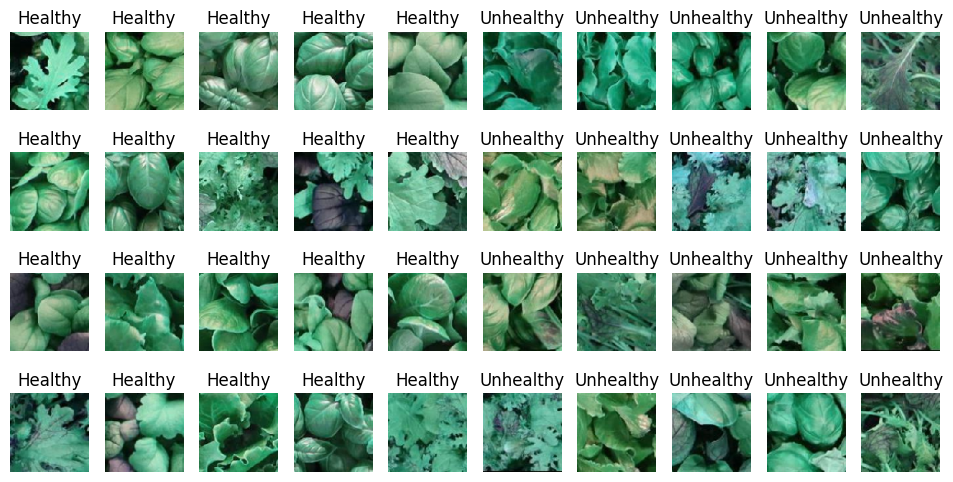

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have two lists: 'image' containing image data and 'y' containing labels
# You can use these lists to filter images based on their labels.

# Create an index array to filter "healthy" and "unhealthy" images
healthy_indices = np.where(y == "healthy")[0]
unhealthy_indices = np.where(y == "unhealthy")[0]

# Take the first 20 images from each class
num_images_per_class = 20
healthy_images = images[healthy_indices[:num_images_per_class]]
unhealthy_images = images[unhealthy_indices[:num_images_per_class]]

# Create subplots to display the images
fig, axs = plt.subplots(4, 10, figsize=(12, 6))

# Display the first 20 healthy images
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(cv2.cvtColor(healthy_images[index], cv2.COLOR_BGR2RGB))
        axs[i, j].set_title("Healthy")
        axs[i, j].axis('off')

# Display the first 20 unhealthy images
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j + 5].imshow(cv2.cvtColor(unhealthy_images[index], cv2.COLOR_BGR2RGB))
        axs[i, j + 5].set_title("Unhealthy")
        axs[i, j + 5].axis('off')

plt.show()


In [ ]:
for key in labels.keys():
  y[y==key] = labels[key]



# Convert labels to categorical format using one-hot encoding
y_cat = tfk.utils.to_categorical(y)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(images, y_cat, random_state=seed, test_size=0.2, stratify=y)



# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)



Training Data Shape: (4003, 96, 96, 3)
Training Label Shape: (4003, 2)
Validation Data Shape: (1001, 96, 96, 3)
Validation Label Shape: (1001, 2)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight



# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=np.argmax(y_train, axis=1))

# Create a dictionary to show the results
class_weight_dict = {class_id: weight for class_id, weight in enumerate(class_weights)}

# Print the class weights as a dictionary
print(class_weight_dict)


{0: 0.8067311567916163, 1: 1.3150459921156372}


In [ ]:
IMG_SHAPE  = X_train.shape[1:]
BATCH_SIZE = 128

INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

EPOCHS = 150
PATIENCE = 15
QUEUE_SIZE = 25
#TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200
REGULARIZATION = 0.1

In [ ]:
inputs = tf.keras.Input(shape = IMG_SHAPE, name = "Input")

data_augmentation = tf.keras.Sequential([
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomContrast(0.75)
], name='preprocessing')

augmented_input  = data_augmentation(inputs)


depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)

point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1", kernel_regularizer=l2(REGULARIZATION))(depth_conv_1)

max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)



depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)

point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2", kernel_regularizer=l2(REGULARIZATION))(depth_conv_2)

max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)



depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)

point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3", kernel_regularizer=l2(REGULARIZATION))(depth_conv_3)

max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)



depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)

point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4", kernel_regularizer=l2(REGULARIZATION))(depth_conv_4)

max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)



depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)

point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5", kernel_regularizer=l2(REGULARIZATION))(depth_conv_5)

max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)



global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)

global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)

global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)

global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)

global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)

concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])



dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)

dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1", kernel_regularizer=l2(REGULARIZATION))(dropout_1)


dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)

dense_2 = Dense(2, activation = "softmax", name = "Output")(dropout_2)



In [ ]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

weight_decay = 1e-5
lr = 0.01

optimizerr = Adam(learning_rate=lr,weight_decay=weight_decay)


model.compile(optimizer =  optimizerr,
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])

model.summary()

In [ ]:
plot_model(model, show_shapes = True, dpi = PLOTS_DPI)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = PATIENCE, restore_best_weights = True)

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    epochs = EPOCHS,
    callbacks = [early_stopping],

    verbose=1
).history

Epoch 1/150
126/126 [==============================] - 7s 24ms/step - loss: 5.2247 - binary_accuracy: 0.6180 - val_loss: 0.6710 - val_binary_accuracy: 0.6194
Epoch 2/150
126/126 [==============================] - 3s 20ms/step - loss: 0.6719 - binary_accuracy: 0.6198 - val_loss: 0.6651 - val_binary_accuracy: 0.6194
Epoch 3/150
126/126 [==============================] - 3s 22ms/step - loss: 0.6663 - binary_accuracy: 0.6198 - val_loss: 0.6646 - val_binary_accuracy: 0.6194
Epoch 4/150
126/126 [==============================] - 3s 21ms/step - loss: 0.6655 - binary_accuracy: 0.6198 - val_loss: 0.6648 - val_binary_accuracy: 0.6194
Epoch 5/150
126/126 [==============================] - 3s 20ms/step - loss: 0.6649 - binary_accuracy: 0.6198 - val_loss: 0.6648 - val_binary_accuracy: 0.6194
Epoch 6/150
126/126 [==============================] - 2s 20ms/step - loss: 0.6652 - binary_accuracy: 0.6198 - val_loss: 0.6648 - val_binary_accuracy: 0.6194
Epoch 7/150
126/126 [==============================]

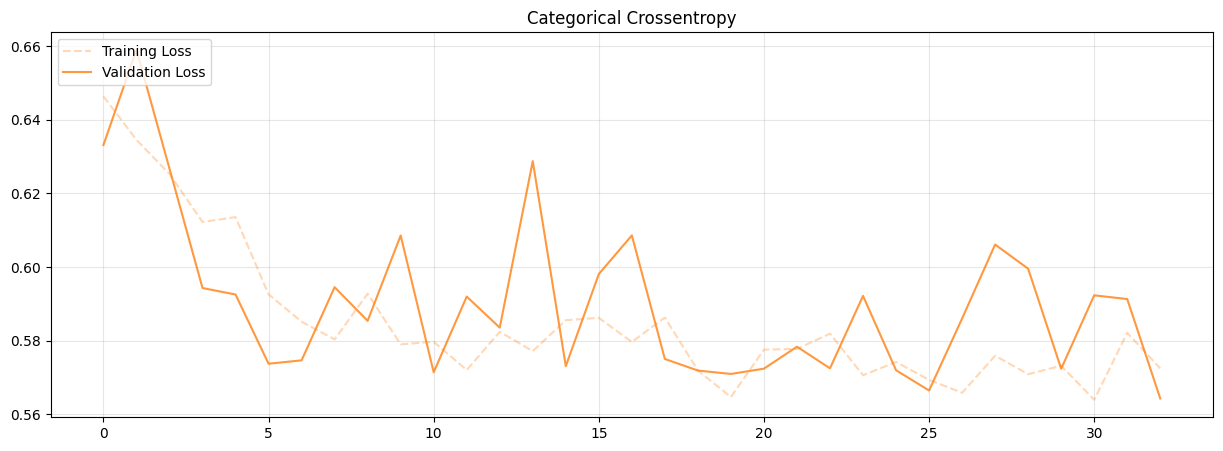

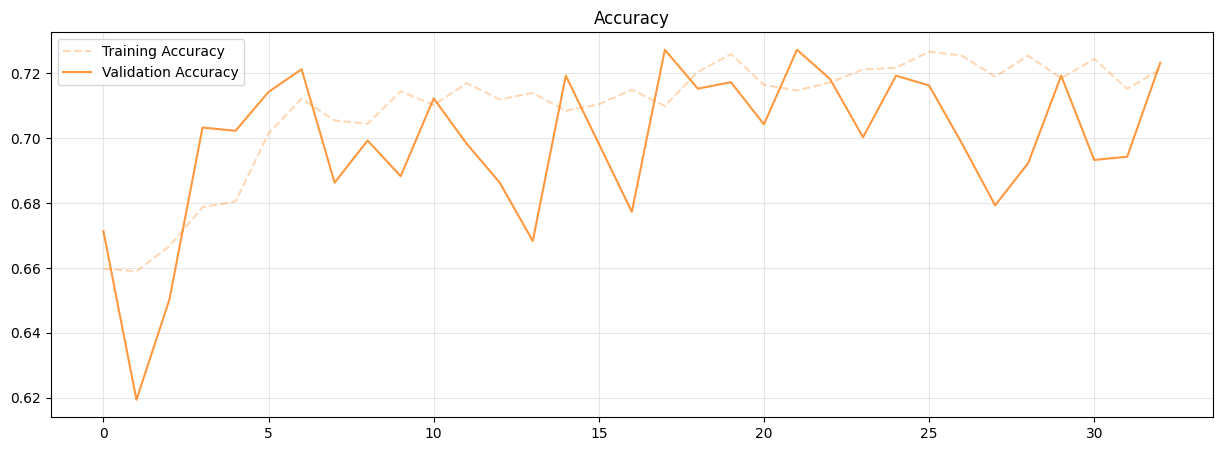

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#ff7f0e')
plt.title('Categorical Crossentropy')
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['binary_accuracy'], label='Training Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_binary_accuracy'], label='Validation Accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/AN2DL_HW_1/Cmplx_V3")